In [1]:
from rebinning import station_radii, draw_wheels, make_concentric_disks, make_disk, station3_boundaries, rebin,assign_colors, make_rebin_regions
import numpy as np
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from ResNet import *
from torch.utils.data import DataLoader


from drawing_utilities import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using:", device)

You are using: cuda


In [39]:
def Show2DLoss(img, vmin=-1.5, vmax=2., title='Loss'):
    fig = plt.figure(figsize =(8, 8))
    img_temp = copy.deepcopy(img)
    cmap = plt.cm.seismic
    cmap.set_bad(color='black')
    img_temp[img_temp==0] = np.nan
    plt.imshow(img_temp, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.show()
    del img_temp

In [3]:
dir = "/eos/cms/store/group/ml/AD4MVDHackathon/ML4DQM_MUON/anomalies/"
file = "hRHGlobalm2_130824_s1.npz"
data = np.load(dir+file)
#data.files has "bad_flag": 1 for good data, -1 for bad data

data_np = np.array(data["bad_flag"])

# Filter data to only include images with a bad flag of 1 or -1
valid_data_filter = np.isin(data["bad_flag"], [-1, 1])

# Apply the filter to the entire dictionary
valid_data = {key: data[key][valid_data_filter] for key in data.files}

print(f"Removed {len(data['bad_flag']) - len(valid_data['bad_flag'])} ambigious images")

Removed 79 ambigious images


In [29]:
valid_data.keys()

dict_keys(['imgs', 'no_rebin_imgs', 'lumis', 'entry', 'num', 'run_min', 'run_max', 'lumi_min', 'lumi_max', 'bad_flag'])

In [4]:
valid_imgs = valid_data["no_rebin_imgs"]
valid_labels = valid_data["bad_flag"] == -1

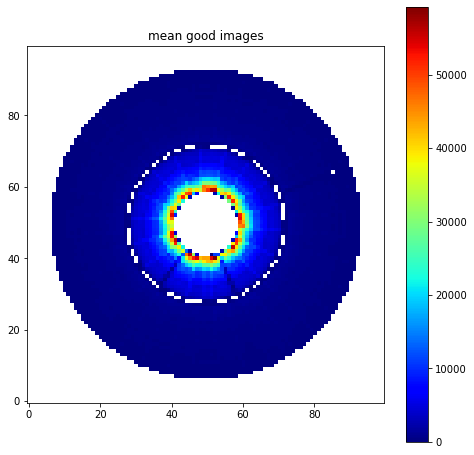

In [5]:
mean_matrix = np.mean(valid_imgs[valid_labels == False], axis=0)
Show2Dimg(mean_matrix, title="Unbinned Mean Good Images")

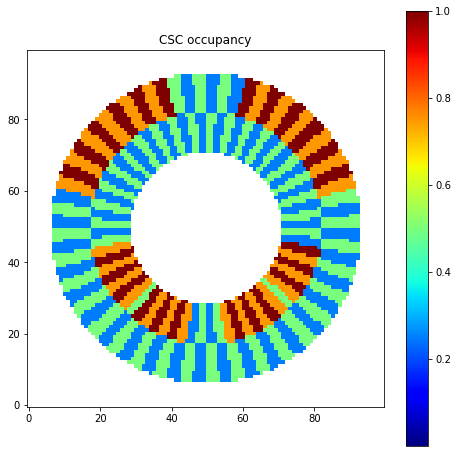

In [6]:
inner_radius,outer_radius = station3_boundaries()
regions = make_rebin_regions(mean_matrix,inner_radius,outer_radius,wheel_division=2, radial_division=2)
Show2Dimg(assign_colors(regions))
valid_imgs = np.array([rebin(regions, img) for img in valid_imgs])

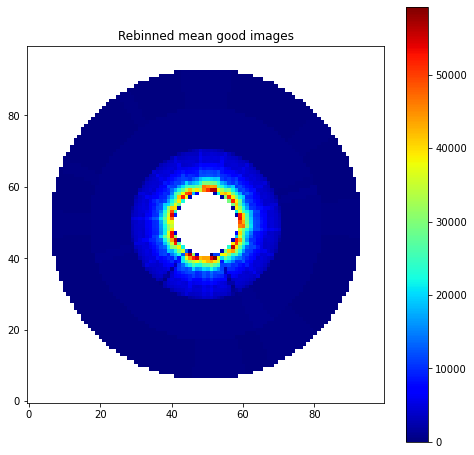

In [7]:
mean_matrix = np.mean(valid_imgs[valid_labels == False], axis=0)
Show2Dimg(mean_matrix, title="Rebinned Mean Good Images")
mean_matrix[mean_matrix == 0] = np.nan

In [8]:
out_label = "240724"
# Load the saved state 
model = ResNetAE(1, 3, [16, 32, 64], img_size=(100,100)).to(device)
model.load_state_dict(torch.load("model_"+out_label+".pth"))

# Assign labels to the images: 0 for good, 1 for bad
valid_labels = valid_labels.astype(int)
mixed_dataset = [[label,(torch.tensor(img, dtype=torch.float32)).unsqueeze(0)] for label, img in zip(valid_labels, valid_imgs)]

# Create a DataLoader for the mixed dataset
mixed_loader = DataLoader(dataset=mixed_dataset,
                          batch_size=64,
                          num_workers=10,
                          shuffle=False)

#### Studying distribution of losses

In [9]:
empty_img = np.zeros((100,100), dtype=float)
#make a map of distances of each pixel from the center
center = 49.5, 49.5
#use np.indices
x, y = np.indices(empty_img.shape)
inner_radius, outer_radius = station3_boundaries()
distances = np.sqrt((x - center[0])**2 + (y - center[1])**2)
inner_region = np.where(distances < inner_radius,1.,0.)
outer_region = np.where(distances > inner_radius,1.,0.)

In [10]:
%%time

# Initialize lists to store losses for each region
inner_max_good = []
inner_min_good = []
outer_max_good = []
outer_min_good = []

inner_max_bad = []
inner_min_bad = []
outer_max_bad = []
outer_min_bad = []

for i, (labels,imgs) in enumerate(mixed_loader):
    imgs = imgs.to(device)
    reco_imgs = model(imgs)
    losses = imgs - reco_imgs
    

    
    losses = losses.view(losses.shape[0], -1).cpu().detach().numpy()
    losses /= mean_matrix.reshape(1, -1)
        
    
    # Calculate losses for inner and outer regions
    inner = losses * inner_region.reshape(1, -1)
    outer = losses * outer_region.reshape(1, -1)
    
    # Calculate max and min losses for each region
    inner_max = np.nanmax(inner, axis=1) 
    inner_min = np.nanmin(inner, axis=1) 
    outer_max = np.nanmax(outer, axis=1) 
    outer_min = np.nanmin(outer, axis=1) 
    
    labels = labels.numpy()  # convert labels to numpy array for boolean indexing
    
    # Append losses to corresponding lists
    inner_max_good.extend(inner_max[labels == 0])
    inner_min_good.extend(inner_min[labels == 0])
    outer_max_good.extend(outer_max[labels == 0])
    outer_min_good.extend(outer_min[labels == 0])
    
    inner_max_bad.extend(inner_max[labels != 0])
    inner_min_bad.extend(inner_min[labels != 0])
    outer_max_bad.extend(outer_max[labels != 0])
    outer_min_bad.extend(outer_min[labels != 0])

# Create dictionaries with all the data
good_data = {
    'inner_max_good': inner_max_good,
    'inner_min_good': inner_min_good,
    'outer_max_good': outer_max_good,
    'outer_min_good': outer_min_good,
}

bad_data = {
    'inner_max_bad': inner_max_bad,
    'inner_min_bad': inner_min_bad,
    'outer_max_bad': outer_max_bad,
    'outer_min_bad': outer_min_bad,
}

# Convert the dictionaries to DataFrames
good_df = pd.DataFrame(good_data)
bad_df = pd.DataFrame(bad_data)

CPU times: user 1.44 s, sys: 667 ms, total: 2.11 s
Wall time: 2.35 s


In [11]:
def plot_data(
    ax,
    good_df,
    bad_df,
    good_col,
    bad_col,
    percentiles_min,
    percentiles_max,
    color_good,
    color_bad,
    label_good,
    label_bad,
    threshold_type="upper",
):
    good_bounds = np.percentile(good_df[good_col], [percentiles_min, percentiles_max])
    bad_bounds = np.percentile(bad_df[bad_col], [percentiles_min, percentiles_max])
    x_range = [min(good_bounds[0], bad_bounds[0]), max(good_bounds[1], bad_bounds[1])]

    ax.set_xlim(x_range)

    num_bins = 100
    bins = np.linspace(x_range[0], x_range[1], num_bins)

    sns.histplot(
        good_df[good_col],
        ax=ax,
        color=color_good,
        label=label_good,
        kde=False,
        bins=bins,
        stat="density",
    )
    sns.histplot(
        bad_df[bad_col],
        ax=ax,
        color=color_bad,
        label=label_bad,
        kde=False,
        element="step",
        fill=False,
        bins=bins,
        stat="density",
    )

    ax.set_yscale("log")

    if threshold_type == "upper":
        n_good_selected = [
            len(good_df[good_df[good_col] > threshold]) for threshold in bins
        ]
        n_bad_selected = [
            len(bad_df[bad_df[bad_col] > threshold]) for threshold in bins
        ]
    else:  # 'lower'
        n_good_selected = [
            len(good_df[good_df[good_col] < threshold]) for threshold in bins
        ]
        n_bad_selected = [
            len(bad_df[bad_df[bad_col] < threshold]) for threshold in bins
        ]

    total_bad = bad_df.shape[0]
    total_good = good_df.shape[0]
    tp = np.array(n_bad_selected)
    fp = np.array(n_good_selected)
    fn = np.array([total_bad - n_bad_selected[i] for i in range(len(bins))])
    tn = np.array([total_good - n_good_selected[i] for i in range(len(bins))])

    f1 = 2 * tp / (2 * tp + fp + fn)

    threshold = bins[np.argmax(f1)]
    ax.plot(
        bins, f1, color="black", label="F1 Score"
    )
    ax.axvline(threshold, color="black", linestyle="--", label="Best Threshold")
    ax.legend()

    # Calculate precision, recall, accuracy and F1 score at the chosen threshold
    tp_at_threshold = tp[np.argmax(f1)]
    fp_at_threshold = fp[np.argmax(f1)]
    fn_at_threshold = fn[np.argmax(f1)]
    tn_at_threshold = tn[np.argmax(f1)]
    

    precision = tp_at_threshold / (tp_at_threshold + fp_at_threshold)
    accuracy = (tp_at_threshold + tn_at_threshold) / (
        tp_at_threshold + tn_at_threshold + fp_at_threshold + fn_at_threshold
    )
    tpr = tp_at_threshold / (tp_at_threshold + fn_at_threshold)
    f1_score = 2 * precision * tpr / (precision + tpr)
    fpr = fp_at_threshold / (fp_at_threshold + tn_at_threshold)
    
    # Return the metrics in a dictionary
    metrics = {
        "f1_score": f1_score,
        "accuracy": accuracy,
        "precision": precision,
        "tpr": tpr,
        "fpr": fpr,
        "best_threshold": threshold,  # Add the best threshold value
    }

    return metrics

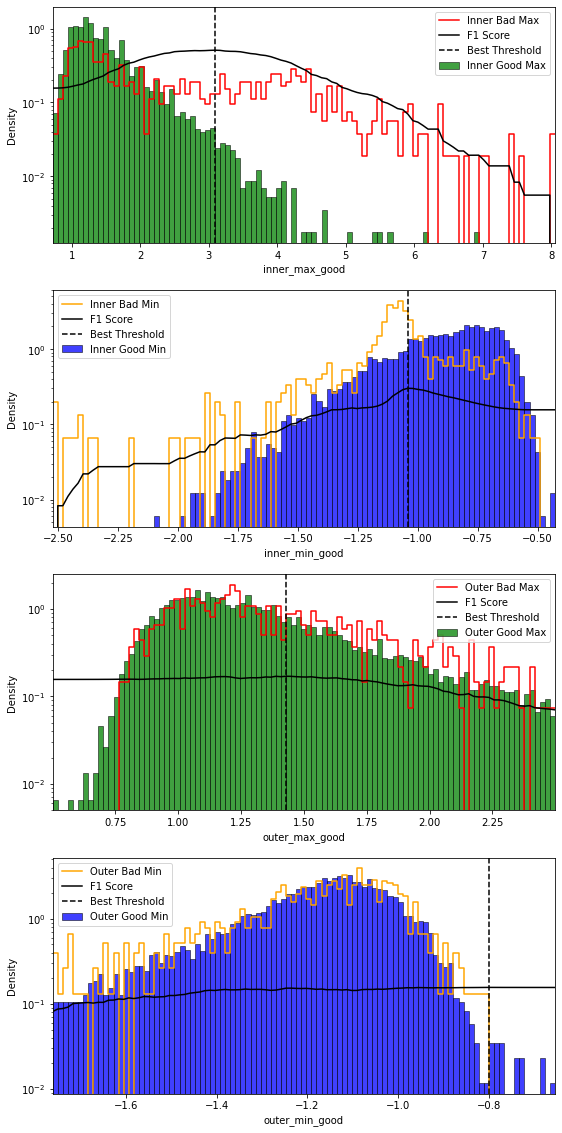

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with 4 subplots
fig, axs = plt.subplots(4, figsize=(9, 20))

inner_percentiles_max = [0, 100]
inner_percentiles_min = [0, 100]

outer_percentiles_max = [0, 95]
outer_percentiles_min = [5, 100]


inner_max_dict = plot_data(axs[0], good_df, bad_df, "inner_max_good", "inner_max_bad", inner_percentiles_max[0], inner_percentiles_max[1], "green", "red", "Inner Good Max", "Inner Bad Max", 'upper')
inner_min_dict = plot_data(axs[1], good_df, bad_df, "inner_min_good", "inner_min_bad", inner_percentiles_min[0], inner_percentiles_min[1], "blue", "orange", "Inner Good Min", "Inner Bad Min", 'lower')
outer_max_dict = plot_data(axs[2], good_df, bad_df, "outer_max_good", "outer_max_bad", outer_percentiles_max[0], outer_percentiles_max[1], "green", "red", "Outer Good Max", "Outer Bad Max", 'upper')
outer_min_dict = plot_data(axs[3], good_df, bad_df, "outer_min_good", "outer_min_bad", outer_percentiles_min[0], outer_percentiles_min[1], "blue", "orange", "Outer Good Min", "Outer Bad Min", 'lower')

plt.show()

In [13]:
print("inner max results:\n", inner_max_dict)
print("inner min results:\n", inner_min_dict)
print("outer max results:\n", outer_max_dict)
print("outer min results:\n", outer_min_dict)

bad_loss_low = [inner_min_dict["best_threshold"], outer_min_dict["best_threshold"]]
bad_loss_high = [inner_max_dict["best_threshold"], outer_max_dict["best_threshold"]]
print(bad_loss_low)
print(bad_loss_high)

inner max results:
 {'f1_score': 0.5101860053144376, 'accuracy': 0.9347261567516525, 'precision': 0.7007299270072993, 'tpr': 0.4011142061281337, 'fpr': 0.0158627805003869, 'best_threshold': 3.091781421141191}
inner min results:
 {'f1_score': 0.30176138251910933, 'accuracy': 0.7520066100094429, 'precision': 0.19816673941510257, 'tpr': 0.6323119777158774, 'fpr': 0.23690998194480267, 'best_threshold': -1.041453692648146}
outer max results:
 {'f1_score': 0.16981648863325116, 'accuracy': 0.642233238904627, 'precision': 0.10569382884418684, 'tpr': 0.43175487465181056, 'fpr': 0.33827701831312873, 'best_threshold': 1.4294664561146435}
outer min results:
 {'f1_score': 0.15652932199694788, 'accuracy': 0.08663833805476864, 'precision': 0.08491012298959319, 'tpr': 1.0, 'fpr': 0.9979365488779984, 'best_threshold': -0.799558937128144}
[-1.041453692648146, -0.799558937128144]
[3.091781421141191, 1.4294664561146435]


#### Rebinning for inner-disk

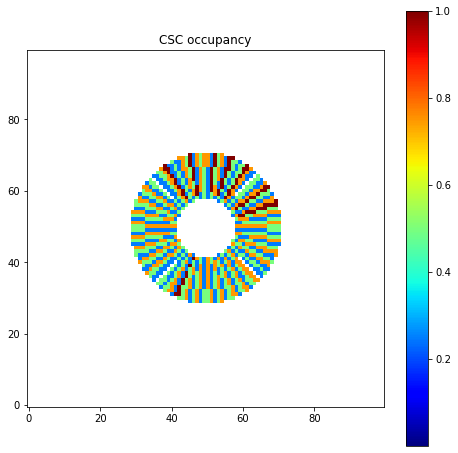

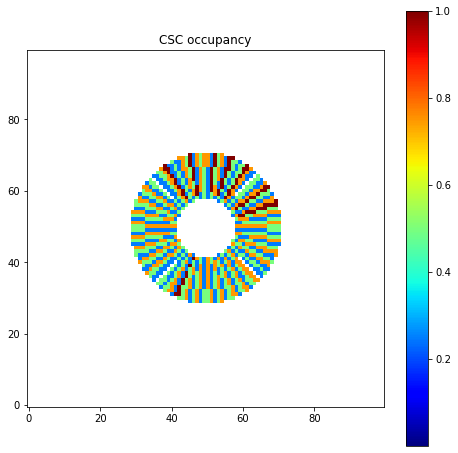

In [14]:
empty_img = np.zeros((100,100), dtype=np.int16)
hole = make_disk(empty_img, 8,1.)
hole = np.abs(hole-1)
inner_slices = draw_wheels(50,3)
disks_radii = np.linspace(8.,inner_radius,2)
hole *= make_disk(empty_img, inner_radius,1.)
inner_disks = make_concentric_disks(50,disks_radii)
inner_regions = inner_slices*inner_disks*hole

my_inner_regions = make_rebin_regions(mean_matrix,8.,inner_radius,wheel_division=3, radial_division=1)

Show2Dimg(assign_colors(inner_regions))
Show2Dimg(assign_colors(my_inner_regions))
#Queste regioni così sono un po' brutte

In [15]:
%%time


# Initialize lists to store losses for each region
inner_max_good = []
inner_min_good = []
outer_max_good = []
outer_min_good = []

inner_max_bad = []
inner_min_bad = []
outer_max_bad = []
outer_min_bad = []

for i, (labels,imgs) in enumerate(mixed_loader):
    imgs = imgs.to(device)
    reco_imgs = model(imgs)
    losses = imgs - reco_imgs
    

    
    losses = losses.view(losses.shape[0], -1).cpu().detach().numpy()
    losses /= mean_matrix.reshape(1, -1)
    losses = losses.reshape(losses.shape[0],100,100)
    
    losses = [rebin(regions,loss) for loss in losses]
    losses = np.array([rebin(my_inner_regions,loss) for loss in losses])
    losses = losses.reshape(losses.shape[0], -1)
    
          
    
    # Calculate losses for inner and outer regions
    inner = losses * inner_region.reshape(1, -1)
    outer = losses * outer_region.reshape(1, -1)
    
    # Calculate max and min losses for each region
    inner_max = np.nanmax(inner, axis=1) 
    inner_min = np.nanmin(inner, axis=1) 
    outer_max = np.nanmax(outer, axis=1) 
    outer_min = np.nanmin(outer, axis=1) 
    
    labels = labels.numpy()  # convert labels to numpy array for boolean indexing
    
    # Append losses to corresponding lists
    inner_max_good.extend(inner_max[labels == 0])
    inner_min_good.extend(inner_min[labels == 0])
    outer_max_good.extend(outer_max[labels == 0])
    outer_min_good.extend(outer_min[labels == 0])
    
    inner_max_bad.extend(inner_max[labels != 0])
    inner_min_bad.extend(inner_min[labels != 0])
    outer_max_bad.extend(outer_max[labels != 0])
    outer_min_bad.extend(outer_min[labels != 0])

# Create dictionaries with all the data
good_data = {
    'inner_max_good': inner_max_good,
    'inner_min_good': inner_min_good,
    'outer_max_good': outer_max_good,
    'outer_min_good': outer_min_good,
}

bad_data = {
    'inner_max_bad': inner_max_bad,
    'inner_min_bad': inner_min_bad,
    'outer_max_bad': outer_max_bad,
    'outer_min_bad': outer_min_bad,
}

# Convert the dictionaries to DataFrames
good_df = pd.DataFrame(good_data)
bad_df = pd.DataFrame(bad_data)

CPU times: user 3.17 s, sys: 746 ms, total: 3.92 s
Wall time: 4.14 s


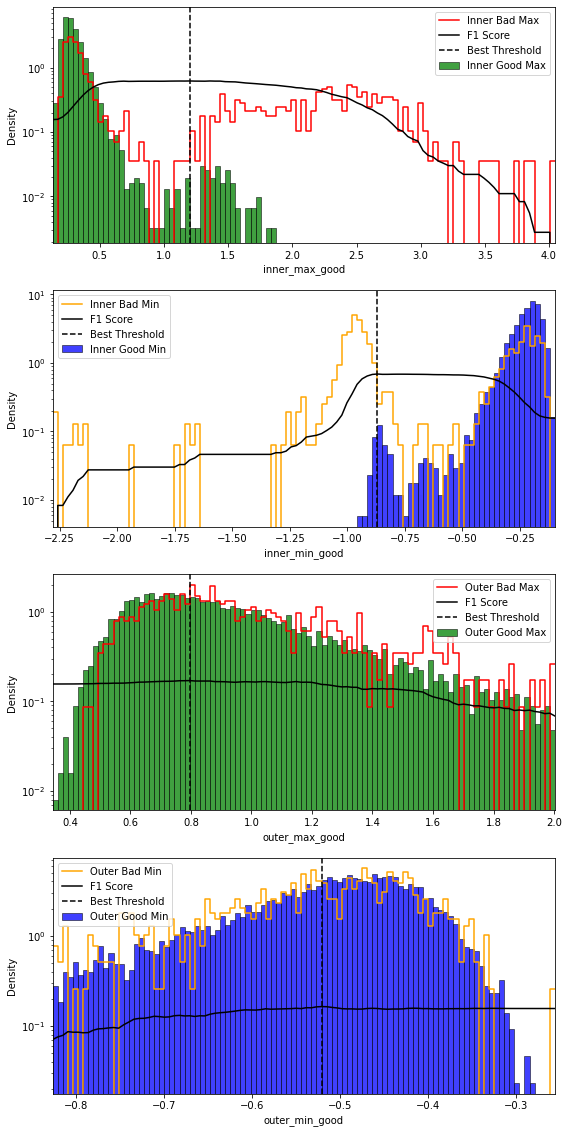

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with 4 subplots
fig, axs = plt.subplots(4, figsize=(9, 20))

inner_percentiles_max = [0, 100]
inner_percentiles_min = [0, 100]

outer_percentiles_max = [0, 95]
outer_percentiles_min = [5, 100]


inner_max_dict = plot_data(axs[0], good_df, bad_df, "inner_max_good", "inner_max_bad", inner_percentiles_max[0], inner_percentiles_max[1], "green", "red", "Inner Good Max", "Inner Bad Max", 'upper')
inner_min_dict = plot_data(axs[1], good_df, bad_df, "inner_min_good", "inner_min_bad", inner_percentiles_min[0], inner_percentiles_min[1], "blue", "orange", "Inner Good Min", "Inner Bad Min", 'lower')
outer_max_dict = plot_data(axs[2], good_df, bad_df, "outer_max_good", "outer_max_bad", outer_percentiles_max[0], outer_percentiles_max[1], "green", "red", "Outer Good Max", "Outer Bad Max", 'upper')
outer_min_dict = plot_data(axs[3], good_df, bad_df, "outer_min_good", "outer_min_bad", outer_percentiles_min[0], outer_percentiles_min[1], "blue", "orange", "Outer Good Min", "Outer Bad Min", 'lower')

plt.show()

In [17]:
print("inner max results:\n", inner_max_dict)
print("inner min results:\n", inner_min_dict)
print("outer max results:\n", outer_max_dict)
print("outer min results:\n", outer_min_dict)

bad_loss_low = [inner_min_dict["best_threshold"], outer_min_dict["best_threshold"]]
bad_loss_high = [inner_max_dict["best_threshold"], outer_max_dict["best_threshold"]]
print(bad_loss_low)
print(bad_loss_high)

inner max results:
 {'f1_score': 0.6213592233009709, 'accuracy': 0.9493626062322946, 'precision': 0.8481927710843373, 'tpr': 0.49025069637883006, 'fpr': 0.008124838792881093, 'best_threshold': 1.1996045112609863}
inner min results:
 {'f1_score': 0.689165186500888, 'accuracy': 0.9586874409820585, 'precision': 0.9509803921568627, 'tpr': 0.5403899721448467, 'fpr': 0.0025793139025019345, 'best_threshold': -0.8694145270068236}
outer max results:
 {'f1_score': 0.17072760880524285, 'accuracy': 0.41749291784702547, 'precision': 0.09707624689470667, 'tpr': 0.7075208913649025, 'fpr': 0.6093629094660821, 'best_threshold': 0.7957787665453824}
outer min results:
 {'f1_score': 0.16382405745062836, 'accuracy': 0.5601983002832861, 'precision': 0.09764579989299091, 'tpr': 0.5083565459610028, 'fpr': 0.43500128965695123, 'best_threshold': -0.5209272771170645}
[-0.8694145270068236, -0.5209272771170645]
[1.1996045112609863, 0.7957787665453824]


In [18]:
import numpy as np
import matplotlib.patches as mpatches


class ImageProcessor:
    _instance = None
    BAD = -1.
    GOOD = 1.

    def __new__(cls, *args, **kwargs):
        if not cls._instance:
            cls._instance = super(ImageProcessor, cls).__new__(cls)
        return cls._instance

    def __init__(self, bad_loss_low, bad_loss_high, region_radii, mean_matrix):
        self.bad_loss_low = bad_loss_low
        self.bad_loss_high = bad_loss_high
        self.region_radii = sorted(region_radii)
        self.shape = mean_matrix.shape
        self.center = [self.shape[0]//2 - 0.5, self.shape[1]//2 - 0.5]
        self.mask = np.where(mean_matrix > 0, self.GOOD, 0.)
        self.radial_distance = self.calculate_radial_distance()

    def process_image(self, image):
        radial_distance = self.radial_distance
        previous_radius = 0
        for i,radius in enumerate(self.region_radii):
            mask = (radial_distance >= previous_radius) & (radial_distance < radius)
            image = np.where(mask & ((image < self.bad_loss_low[i] ) | (image > self.bad_loss_high[i])), self.BAD, image)
            previous_radius = radius
        mask = radial_distance >= previous_radius
        image = np.where(mask & ((image < self.bad_loss_low[-1]) | (image > self.bad_loss_high[-1])), self.BAD, image)
        image = np.where(image != self.BAD, self.GOOD, image)

        return image
    

    def plot_image(self, image, title="Image"):
        fig, ax = plt.subplots(figsize=(8,8))

        # Create an RGB image with all pixels set to green
        rgb_image = np.ones((image.shape[0], image.shape[1], 3))
        rgb_image[self.mask == self.GOOD] = [0, 1, 0]

        # Set the pixels where image == self.BAD to red
        rgb_image[image == self.BAD] = [1, 0, 0]

        im = ax.imshow(rgb_image)
        plt.gca().invert_yaxis()
        plt.title(title)

        # Create a red patch for BAD pixels and a green patch for GOOD pixels
        red_patch = mpatches.Patch(color='red', label='BAD')
        green_patch = mpatches.Patch(color='green', label='GOOD')

        # Add the patches to the legend
        plt.legend(handles=[red_patch, green_patch])

        # Create an invisible colorbar
        cbar = fig.colorbar(im, ticks=[])
        cbar.ax.set_visible(False)

        plt.show()

    def calculate_radial_distance(self):
        y, x = np.indices(self.shape)
        return np.sqrt((x - self.center[0])**2 + (y - self.center[1])**2)
    
    def is_bad_image(self, image):
        bad_pixels = self.process_image(image) == self.BAD
        radial_distance = self.radial_distance
        regions_status = []
        previous_region = 0
        for region in self.region_radii:
            region_bad_pixels = bad_pixels & (radial_distance >= previous_region) & (radial_distance < region)
            regions_status.append(np.any(region_bad_pixels))
            previous_region = region
        region_bad_pixels = bad_pixels & (radial_distance >= previous_region)
        regions_status.append(np.any(region_bad_pixels))
        return regions_status

In [19]:
image_processor = ImageProcessor(bad_loss_low, bad_loss_high, [21], mean_matrix)


In [20]:
%%time

image_processor = ImageProcessor(bad_loss_low, bad_loss_high, [21], mean_matrix)

frames = []  # List to store DataFrame rows

for main_index, (labels,imgs) in enumerate(mixed_loader):
    true_labels = (labels == 1).numpy()
    imgs = imgs.to(device)
    reco_imgs = model(imgs)
    losses = imgs - reco_imgs
    

    
    losses = losses.view(losses.shape[0], -1).cpu().detach().numpy()
    losses /= mean_matrix.reshape(1, -1)
    losses = losses.reshape(losses.shape[0],100,100)
    losses = [rebin(regions,loss) for loss in losses]
    losses = np.array([rebin(my_inner_regions,loss) for loss in losses])
    
    # Check if the image is good
    label_areas = [image_processor.is_bad_image(loss) for loss in losses]
    # Add the information to the DataFrame
    for batch_index, (true_label, label_area) in enumerate(zip(true_labels, label_areas)):
        row = {'true_label': true_label}
        for j, bad in enumerate(label_area):
            row[f'region_{j+1}'] = bad
        frames.append(row)


# Convert list of dictionaries to DataFrame
df = pd.DataFrame(frames)
df['label'] = df.filter(like='region_').any(axis=1)

CPU times: user 3.56 s, sys: 810 ms, total: 4.37 s
Wall time: 4.57 s


In [22]:
from sklearn.metrics import confusion_matrix

def calculate_weighted_confusion_matrix(df, true_label_col, pred_label_col):
    # Calculate the confusion matrix
    y_true = df[true_label_col]
    y_pred = df[pred_label_col]

    n_actually_bad = df[true_label_col].sum()
    n_actually_good = len(df) - n_actually_bad

    # Calculate the ratio
    ratio = n_actually_good / n_actually_bad

    # Calculate weights
    weights = df[true_label_col].apply(lambda x: 1 if x == 1 else 1/ratio)

    # Calculate weighted confusion matrix
    cm = confusion_matrix(y_true, y_pred, sample_weight=weights)

    # Unpack the confusion matrix
    tn, fp, fn, tp = cm.ravel()

    return tn, fp, fn, tp

In [23]:

true_label_col='true_label'
pred_label_col='region_1'
# Print the confusion matrix
tn, fp, fn, tp = calculate_weighted_confusion_matrix(df, true_label_col,pred_label_col)
print(f'Weighted true positives: {tp}')
print(f'Weighted false positives: {fp}')
print(f'Weighted true negatives: {tn}')
print(f'Weighted false negatives: {fn}')

# Create boolean masks for each condition
tp_mask = (df[true_label_col] == True) & (df[pred_label_col] == True)
fp_mask = (df[true_label_col] == False) & (df[pred_label_col] == True)
fn_mask = (df[true_label_col] == True) & (df[pred_label_col] == False)
tn_mask = (df[true_label_col] == False) & (df[pred_label_col] == False)

# Get the indices of tp, fp, fn, tn events
tp_indices = df[tp_mask].index.to_numpy()
fp_indices = df[fp_mask].index.to_numpy()
fn_indices = df[fn_mask].index.to_numpy()
tn_indices = df[tn_mask].index.to_numpy()


Weighted true positives: 688.0
Weighted false positives: 7.6855816352850255
Weighted true negatives: 710.3144183647053
Weighted false negatives: 30.0


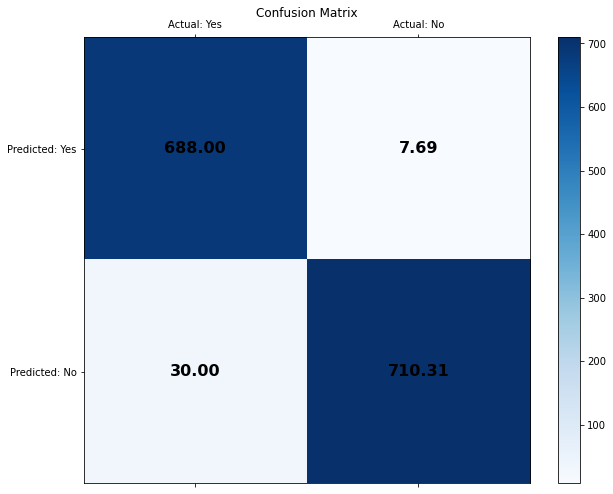

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 2x2 confusion matrix
confusion_mat = np.array([[tp, fp], [fn, tn]])

# Create a heatmap
plt.figure(figsize=(10, 8))
plt.matshow(confusion_mat, cmap='Blues', fignum=1)

# Add colorbar
plt.colorbar()

# Add annotations
for (i, j), z in np.ndenumerate(confusion_mat):
    plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', fontsize=16, color='black', weight='bold')

# Add labels to the plot
plt.title('Confusion Matrix', pad=20)
plt.xticks([0, 1], ['Actual: Yes', 'Actual: No'])
plt.yticks([0, 1], ['Predicted: Yes', 'Predicted: No'])

# Show the plot
plt.show()

In [25]:
# Calculate the True Positive Rate (TPR), also known as recall
tpr = tp / (tp + fn)
print(f'True Positive Rate (TPR): {tpr:.2f}')

# Calculate the False Positive Rate (FPR)
fpr = fp / (fp + tn)
print(f'False Positive Rate (FPR): {fpr:.2f}')

# Calculate the Precision
precision = tp / (tp + fp)
print(f'Precision: {precision:.2f}')

# Calculate the F1 score
f1 = 2 * (precision * tpr) / (precision + tpr)
print(f'F1 Score: {f1:.2f}')

# Calculate the accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f'Accuracy: {accuracy:.2f}')

True Positive Rate (TPR): 0.96
False Positive Rate (FPR): 0.01
Precision: 0.99
F1 Score: 0.97
Accuracy: 0.97


True Positive Example:
from run 380306 and lumi interval 193-207 (14 lumis)


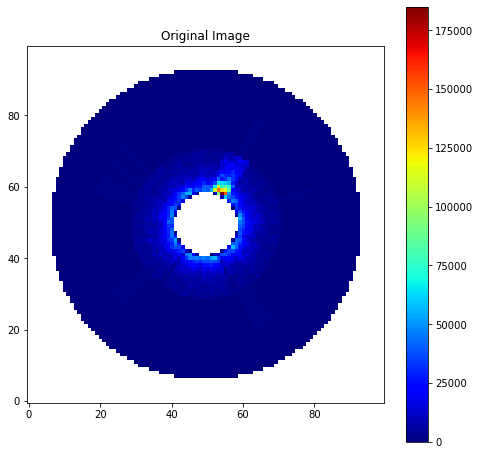

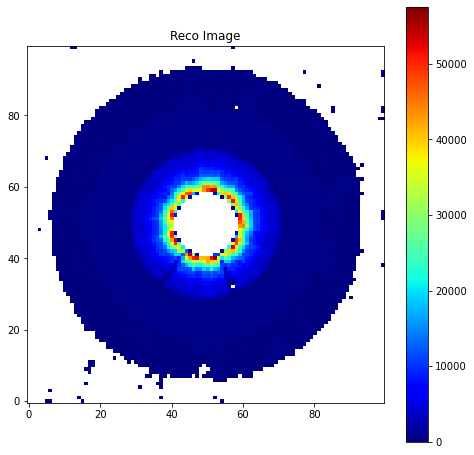

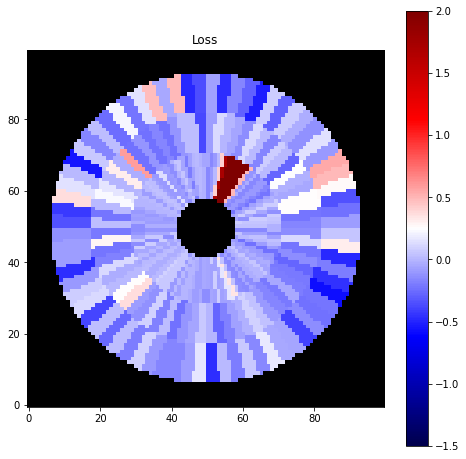

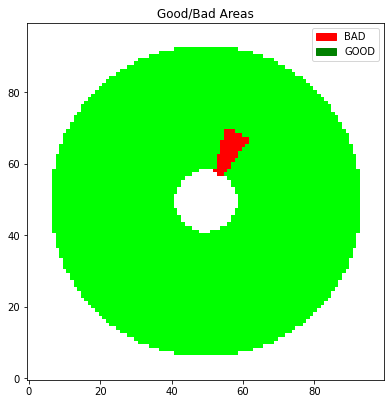

False Positive Example:
from run 380399 and lumi interval 179-193 (14 lumis)


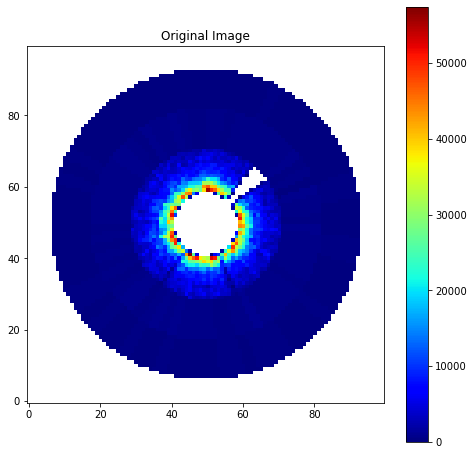

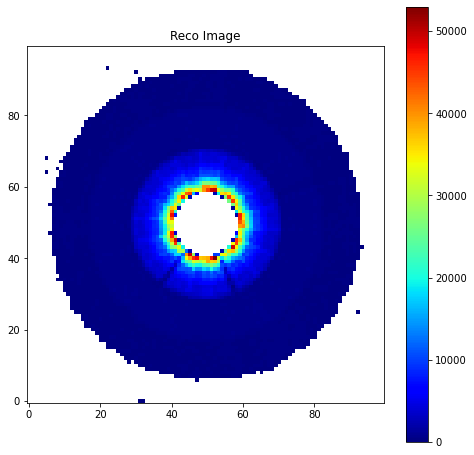

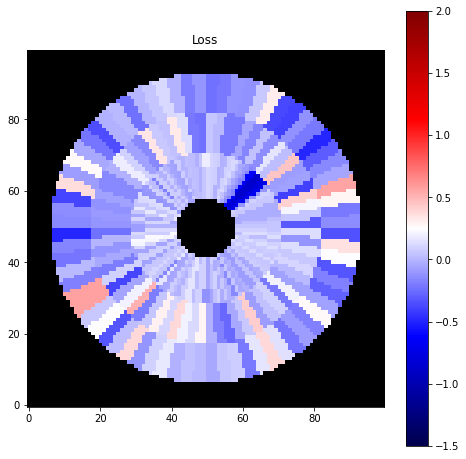

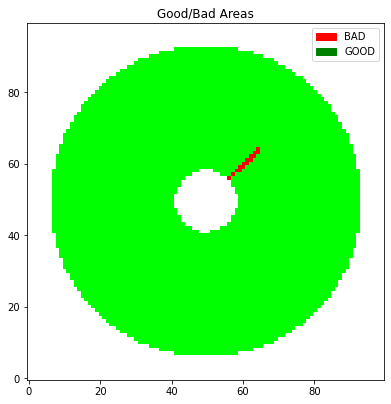

False Negative Example:
from run 380348 and lumi interval 13-28 (15 lumis)


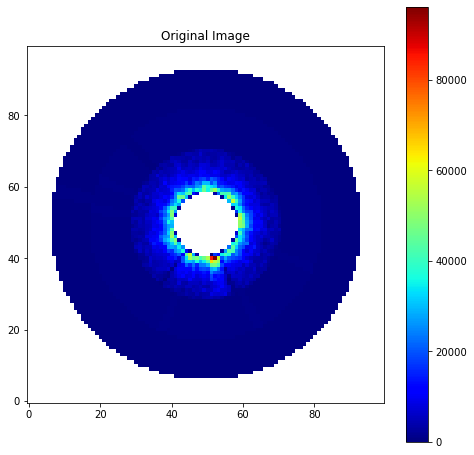

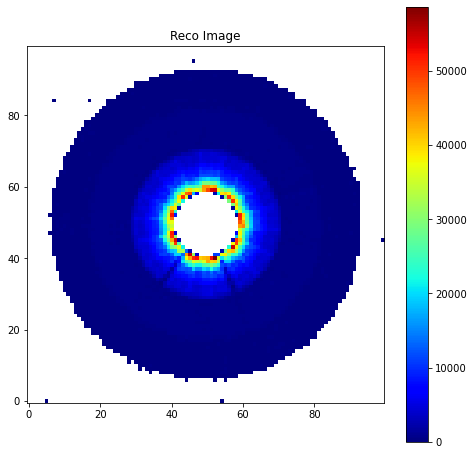

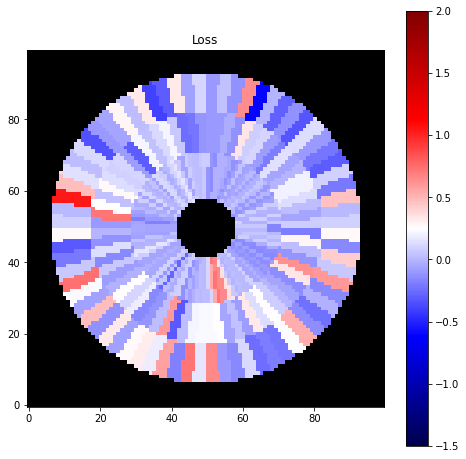

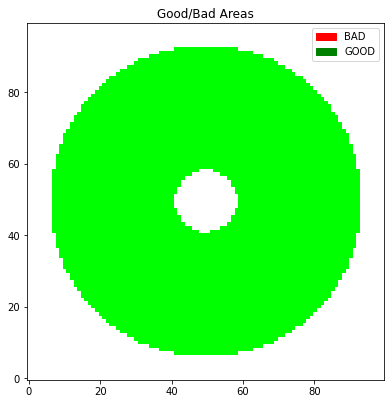

True Negative Example:
from run 380306 and lumi interval 29-63 (34 lumis)


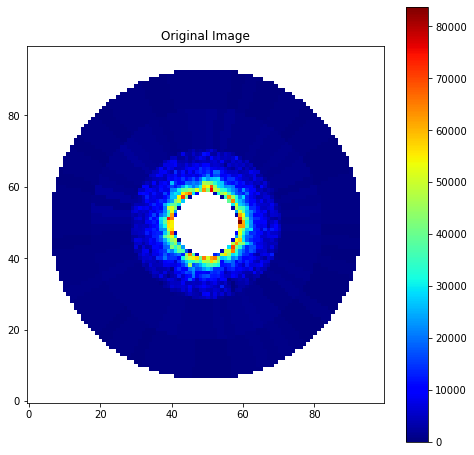

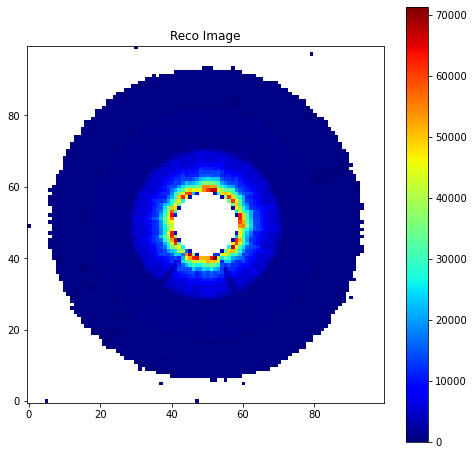

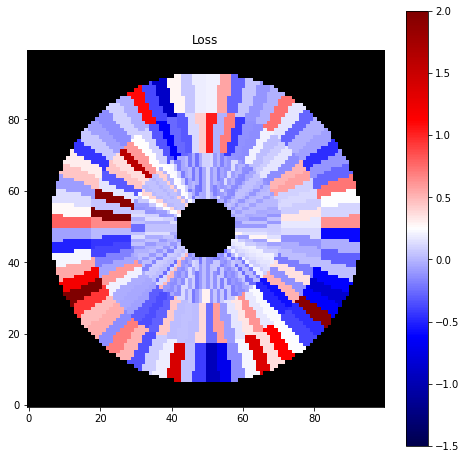

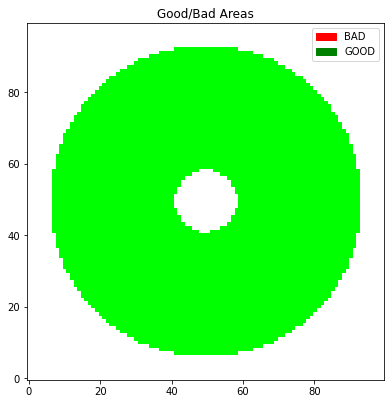

In [40]:
def process_and_plot_image(indices, title, index=0):
    _, img = mixed_dataset[indices[index]]
    print(title)
    run_min, run_max = valid_data["run_min"][indices[index]], valid_data["run_max"][indices[index]]
    lumi_min, lumi_max = valid_data["lumi_min"][indices[index]], valid_data["lumi_max"][indices[index]]

    run_interval = f"from run {run_min}" if run_min == run_max else f"from run interval {run_min}-{run_max}"
    lumi_interval = f"and lumi interval {lumi_min}-{lumi_max} ({lumi_max-lumi_min} lumis)" 

    print(run_interval, lumi_interval)
    Show2Dimg(img[0].numpy(), "Original Image")
    img = img.to(device)
    
    img = img.unsqueeze(0)

    reco_img = model(img)
    loss = img - reco_img
    reco_img = reco_img[0][0].cpu().detach().numpy()
    Show2Dimg(reco_img, "Reco Image")
    

    
    loss = loss.view(loss.shape[0], -1).cpu().detach().numpy()
    loss /= mean_matrix.reshape(1, -1)
    loss = loss.reshape(loss.shape[0],100,100)
    loss = loss[0]
    loss = rebin(regions,loss)
    loss = rebin(my_inner_regions,loss)
    
    #mask outer region
    #loss *= inner_region
    
    Show2DLoss(loss, title="Loss")
    loss = image_processor.process_image(loss)
    loss *= inner_region
    image_processor.plot_image(loss, title = "Good/Bad Areas")

process_and_plot_image(tp_indices, "True Positive Example:")
process_and_plot_image(fp_indices, "False Positive Example:")
process_and_plot_image(fn_indices, "False Negative Example:")
process_and_plot_image(tn_indices, "True Negative Example:")